In [30]:
from keras.preprocessing import sequence  
from keras.models import Sequential  
from keras.datasets import boston_housing  
from keras.layers import Dense, Dropout 
# from keras.utils import multi_gpu_model  
# from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras import regularizers  # 正则化  
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd

In [152]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def distance(true_pt, pred_pt):
    def rad(d):
        return d * math.pi / 180.0
    lat1 = true_pt[1]
    lng1 = true_pt[0]
    lat2 = pred_pt[1]
    lng2 = pred_pt[0]
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    print(a)
    
    s = 2 * tf.asin(tf.sqrt(tf.pow(tf.sin(a/2),2) +
    tf.cos(radLat1)*tf.cos(radLat2)*tf.pow(tf.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

In [57]:
# 度量两点距离
import math
def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

In [139]:
from sklearn.utils import shuffle  

# 加载数据集
def load_data(data_path, shuff=True):
    data = pd.read_csv(data_path)
    data = data.fillna(-1)  # Nan值填充
#     print(data.iloc[1000])
    if shuff:   # 将数据集打乱
        data = shuffle(data)
#     print(data.iloc[1000])
    # 构建数据集和标签
    samples = []
    labels = []
    for index, row in data.iterrows():
    # print(row) # 输出每行的索引值
        matrix = []  # 7 * 4
        for i in range(7):
            matrix.append([i+1,
                           row['AsuLevel_' + str(i+1)],
                           row['SignalLevel_' + str(i+1)],
                           row['Dbm_' + str(i+1)]]) # 新数据集中不存在RSSI，使用Dbm(代功率的绝对值)
        # print(matrix)
        samples.append(matrix)
        labels.append([row['Longitude'], row['Latitude']])
    return np.array(samples), np.array(labels)

In [158]:
path = r"./siping_4g.csv"
samples, labels = load_data(path)
print(samples[0], labels[0])
print(samples.shape)
print(labels.shape)

[[  1.  73.   4. -67.]
 [  2.  68.   4. -72.]
 [  3.  -1.  -1.  -1.]
 [  4.  -1.  -1.  -1.]
 [  5.  -1.  -1.  -1.]
 [  6.  -1.  -1.  -1.]
 [  7.  -1.  -1.  -1.]] [121.4938443   31.28455312]
(3479, 7, 4)
(3479, 2)


In [159]:
# 数据变形： (3479, 7, 4)---》 (3479, 7, 4，1)
# samples = samples.reshape(-1, 7,4,1) # -1自动计算
samples = samples.reshape(samples.shape[0], -1)
print(samples.shape)

(3479, 28)


In [160]:
from sklearn.model_selection import train_test_split

# 划分数据集
x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size=0.2)  #划分训练数据、训练标签、验证数据、验证标签
# 转成DataFrame格式方便数据处理
x_train_pd = pd.DataFrame(x_train)  
y_train_pd = pd.DataFrame(y_train)  
x_valid_pd = pd.DataFrame(x_valid)  
y_valid_pd = pd.DataFrame(y_valid)  
# print(x_train_pd.head(5)) 
# print('-------------------') 
# print(y_train_pd.head(5))

# 训练集归一化  
min_max_scaler = MinMaxScaler()  
min_max_scaler.fit(x_train_pd)  
x_train = min_max_scaler.transform(x_train_pd)  

min_max_scaler.fit(y_train_pd)  
y_train = min_max_scaler.transform(y_train_pd)  
  
# 验证集归一化  
min_max_scaler.fit(x_valid_pd)  
x_valid = min_max_scaler.transform(x_valid_pd)  

min_max_scaler.fit(y_valid_pd)  
y_valid = min_max_scaler.transform(y_valid_pd)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(2783, 28)
(2783, 2)
(696, 28)
(696, 2)


In [167]:
# 单CPU or GPU版本，若有GPU则自动切换  
model = Sequential()  # 初始化，很重要！
model.add(Dense(units = 20,   # 输出大小  
                activation='relu',  # 激励函数  
                input_shape=(x_train_pd.shape[1],)  # 输入大小, 也就是列的大小  
                ) 
         )

model.add(Dropout(0.2))  # 丢弃神经元链接概率  

model.add(Dense(units = 15,  
#                 kernel_regularizer=regularizers.l2(0.01),  # 施加在权重上的正则项  
#                 activity_regularizer=regularizers.l1(0.01),  # 施加在输出上的正则项  
                 activation='relu', # 激励函数  
#                  bias_regularizer=regularizers.l1_l2(0.01)  # 施加在偏置向量上的正则项  
                ) 
         )
   
model.add(Dense(units = 2,     
                activation='linear'  # 线性激励函数 回归一般在输出层用这个激励函数  
               )  
         )  
   
print(model.summary())  # 打印网络层次结构  
    
model.compile(loss='mae',  # 损失均方误差 
              optimizer='adam',  # 优化器  
              metrics=['mae']
             )  
# model.compile(optimizer='adam', loss='mse', metrics=[distance])
history = model.fit(x_train, y_train, 
                    epochs=200,  # 迭代次数  
                    batch_size=200,  # 每次用来梯度下降的批处理数据大小  
                    verbose=2,  # verbose：日志冗长度，int：冗长度，0：不输出训练过程，1：输出训练进度，2：输出每一个epoch 
                    validation_data = (x_valid, y_valid)  # 验证集  
                   )

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 20)                580       
                                                                 
 dropout_36 (Dropout)        (None, 20)                0         
                                                                 
 dense_121 (Dense)           (None, 15)                315       
                                                                 
 dense_122 (Dense)           (None, 2)                 32        
                                                                 
Total params: 927
Trainable params: 927
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14/14 - 1s - loss: 0.4489 - mae: 0.4489 - val_loss: 0.3326 - val_mae: 0.3326 - 547ms/epoch - 39ms/step
Epoch 2/200
14/14 - 0s - loss: 0.3185 - mae: 0.3185 - val_loss: 0.2

Epoch 65/200
14/14 - 0s - loss: 0.2101 - mae: 0.2101 - val_loss: 0.2100 - val_mae: 0.2100 - 30ms/epoch - 2ms/step
Epoch 66/200
14/14 - 0s - loss: 0.2086 - mae: 0.2086 - val_loss: 0.2073 - val_mae: 0.2073 - 30ms/epoch - 2ms/step
Epoch 67/200
14/14 - 0s - loss: 0.2079 - mae: 0.2079 - val_loss: 0.2076 - val_mae: 0.2076 - 32ms/epoch - 2ms/step
Epoch 68/200
14/14 - 0s - loss: 0.2074 - mae: 0.2074 - val_loss: 0.2085 - val_mae: 0.2085 - 31ms/epoch - 2ms/step
Epoch 69/200
14/14 - 0s - loss: 0.2077 - mae: 0.2077 - val_loss: 0.2091 - val_mae: 0.2091 - 30ms/epoch - 2ms/step
Epoch 70/200
14/14 - 0s - loss: 0.2073 - mae: 0.2073 - val_loss: 0.2096 - val_mae: 0.2096 - 32ms/epoch - 2ms/step
Epoch 71/200
14/14 - 0s - loss: 0.2080 - mae: 0.2080 - val_loss: 0.2073 - val_mae: 0.2073 - 30ms/epoch - 2ms/step
Epoch 72/200
14/14 - 0s - loss: 0.2079 - mae: 0.2079 - val_loss: 0.2070 - val_mae: 0.2070 - 31ms/epoch - 2ms/step
Epoch 73/200
14/14 - 0s - loss: 0.2077 - mae: 0.2077 - val_loss: 0.2080 - val_mae: 0.208

Epoch 137/200
14/14 - 0s - loss: 0.2033 - mae: 0.2033 - val_loss: 0.2040 - val_mae: 0.2040 - 32ms/epoch - 2ms/step
Epoch 138/200
14/14 - 0s - loss: 0.2026 - mae: 0.2026 - val_loss: 0.2032 - val_mae: 0.2032 - 31ms/epoch - 2ms/step
Epoch 139/200
14/14 - 0s - loss: 0.2012 - mae: 0.2012 - val_loss: 0.2036 - val_mae: 0.2036 - 30ms/epoch - 2ms/step
Epoch 140/200
14/14 - 0s - loss: 0.2010 - mae: 0.2010 - val_loss: 0.2055 - val_mae: 0.2055 - 32ms/epoch - 2ms/step
Epoch 141/200
14/14 - 0s - loss: 0.2016 - mae: 0.2016 - val_loss: 0.2034 - val_mae: 0.2034 - 31ms/epoch - 2ms/step
Epoch 142/200
14/14 - 0s - loss: 0.2029 - mae: 0.2029 - val_loss: 0.2034 - val_mae: 0.2034 - 32ms/epoch - 2ms/step
Epoch 143/200
14/14 - 0s - loss: 0.2016 - mae: 0.2016 - val_loss: 0.2035 - val_mae: 0.2035 - 30ms/epoch - 2ms/step
Epoch 144/200
14/14 - 0s - loss: 0.2011 - mae: 0.2011 - val_loss: 0.2031 - val_mae: 0.2031 - 31ms/epoch - 2ms/step
Epoch 145/200
14/14 - 0s - loss: 0.2011 - mae: 0.2011 - val_loss: 0.2039 - val_m

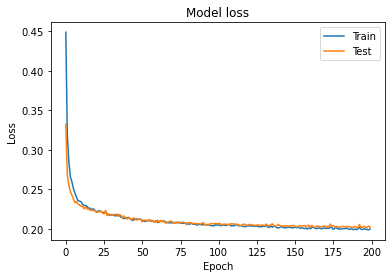

In [168]:
import matplotlib.pyplot as plt  
# 绘制训练 & 验证的损失值  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Test'], loc='best')  
plt.show()

In [164]:
# 预测
y_new = model.predict(x_train) 
# 反归一化还原原始量纲  
min_max_scaler.fit(y_train_pd) 
y_new = min_max_scaler.inverse_transform(y_new) 

err = [distance(p,t) for p, t in zip(y_train_pd.values, y_new)]
print('平均绝对误差 MAE : ', '%.4f'% np.mean(np.abs(err)))
print('均方误差 MSE : ', '%.4f'% np.mean(np.square(err)))
percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
print('平均绝对百分比误差 MAPE : ', '%.4f'% np.mean(percentage_err))
print('绝对误差中位数 MedAE : ', '%.4f'% np.median(err))

87/87 [==============================] - 0s 580us/step
-2.6875766271139412e-05
-3.292141107502644e-06
-1.3427093200624185e-06
-7.900743504318797e-06
1.4032838010269444e-05
7.069050652952491e-06
3.280967378294086e-05
5.070648659510901e-06
-2.391299955839532e-05
5.895764653374158e-06
7.690742642396664e-06
4.431026053741682e-06
-2.391299955839532e-05
2.884768476318911e-07
-9.03258696760556e-06
-6.5358734456788525e-06
-2.5729273291363874e-05
-1.4003620533942218e-05
1.432314080673791e-06
4.56466076730333e-05
-8.5958599105318e-07
-8.054749892627555e-07
1.5129272168845631e-05
-5.527921514536516e-06
-8.437865769317376e-06
-1.5377294960705612e-06
-7.101795177266723e-06
-1.742778489088881e-05
-2.0981337203740402e-05
-4.505758529727011e-06
1.8010551350755577e-05
-2.7042213839201246e-05
5.939677069188853e-06
-5.1510006354393845e-05
4.431026053741682e-06
-1.1099731589414574e-07
-4.77181965718998e-07
3.821038593532222e-06
-7.231079930281048e-06
3.2551168619443516e-06
-5.104714793091603e-07
-2.687576

3.129882730013023e-05
2.1505950281497377e-05
1.8597854643975786e-05
3.459072620914938e-05
2.2915335695650185e-05
5.491105720012435e-06
4.6712730967790606e-06
3.20720565643029e-05
2.515308564887686e-05
2.7875730508553076e-05
3.883143254390653e-06
-4.0043764150565764e-05
5.959687933820845e-06
-2.442635671173754e-06
3.3129750549587555e-05
-1.5091568881242523e-06
1.2523541615072631e-05
-1.9735983167512572e-05
4.028699597924401e-05
4.6576282525245816e-06
1.4757628933659284e-05
1.096814969381299e-05
4.028896143482008e-06
3.0085468183060904e-05
-1.3609356109944848e-05
3.449462060833852e-05
1.652929731754682e-05
7.797074355053724e-07
-8.266928154143649e-06
2.8289334936038024e-05
8.456401455747553e-06
5.823004382354835e-05
-9.432351564253594e-07
-1.1489066730097086e-05
1.6852694470825824e-05
-3.7731342483748875e-07
9.844574387019023e-06
-2.5499993272504184e-07
-1.8067553820833027e-06
-3.156560300698885e-06
-4.546519722925524e-06
2.128697486492026e-05
-2.8146970013631645e-06
-2.159196876561076e-

5.88082470387441e-07
1.686960660907122e-05
3.084892982463394e-05
2.6763518164441003e-05
1.8860830686140417e-07
-5.1310269272519804e-05
-1.3599683934883977e-05
-1.704071023500564e-05
-4.0894631592180986e-06
2.633292975728896e-05
-5.856559087136226e-06
-8.5958599105318e-07
-3.123669255611361e-05
-2.1086585677565495e-07
-3.1503008665167975e-05
-6.185359946453417e-08
2.1938713958724598e-05
3.145951485572507e-05
7.455496717656551e-06
8.879178491794093e-06
3.0389466274427512e-05
-4.527488611938413e-05
4.393514760892003e-05
8.248543905686745e-06
-1.1036939357778053e-05
-1.1918908855435006e-06
-7.165639457684669e-06
-7.62543366594759e-06
2.1200900646278775e-05
1.1752063304726335e-05
1.432314080673791e-06
-2.5943659889504644e-05
-3.1736035260521156e-05
-1.3688736547834424e-05
-9.432351564253594e-07
-1.2095512654797247e-06
-1.9295727698653842e-05
2.4216093974516184e-07
-2.8739979034186902e-05
-2.760813557090014e-05
-4.804818737103034e-06
1.8696941872509143e-07
3.89543396874803e-05
7.805706406349

-9.414631785609195e-06
9.57920312483207e-06
1.2003727766551897e-05
3.4960673799044883e-05
3.310322844796154e-05
-3.2035640883165684e-05
-3.880495177521759e-06
-1.6677987438873387e-05
-2.9738954876457058e-06
-1.392227216912012e-05
-1.0098141837167063e-06
1.0031489093731416e-05
6.727487843471991e-06
-1.041735923401621e-05
4.361791279716698e-06
1.4800046911123133e-05
-5.104714793091603e-07
1.6364654051637118e-05
-1.7540052939413187e-05
-3.040070754134483e-05
-1.9783621622693204e-05
2.2438056663132144e-05
1.8107176289250404e-05
-2.7318521531594087e-06
1.4491529627291833e-05
1.3295757258946495e-05
2.919582792915154e-05
-2.936642593542871e-07
-3.080392887899741e-05
2.9933957241490283e-05
-3.383327461903285e-05
-3.3467089969096975e-05
1.0918287223216083e-06
2.8839091066323874e-06
7.990348265041192e-06
-2.899164562664147e-05
-1.6039602073969483e-05
6.110630961453367e-06
6.333657536217174e-07
1.1019694004965608e-05
-1.3759988336525808e-06
3.217663613330757e-07
-4.1060293842765105e-07
-1.6313619

-5.274023576640197e-06
-3.88988241558641e-05
-2.3998218582788056e-05
-1.309390762993523e-05
-7.462619842524276e-06
2.182431793840145e-06
-1.5708466072350546e-06
1.627690813477134e-05
3.0360850885369217e-05
5.547929566862564e-07
-5.18761910042187e-05
3.7715115182912484e-05
-2.6043528430497176e-05
-2.467147917184498e-06
5.895764653374158e-06
1.0938463330667503e-05
-1.1598537394186259e-05
-8.915139177334552e-06
4.3083315123704224e-05
1.3002413175366989e-05
1.8860830686140417e-07
-2.740868892292525e-06
-2.950563784753779e-05
-1.2000865188266374e-06
-7.063526447081969e-07
-5.470609009683436e-06
3.571093212706433e-05
3.60259382350403e-05
-3.68293308453671e-05
9.513545423556202e-06
-7.936292742094508e-06
7.847654048487307e-06
3.9623171163016835e-06
2.884768476318911e-07
2.4159515725097336e-05
2.1905424445023414e-05
-1.8538738348117256e-05
1.0379072777899623e-05
2.5091622106732103e-05
-3.123669255611361e-05
-1.2662826900267099e-05
5.6462325866202256e-05
-1.0255051879903831e-06
-1.1712468533486

4.994095493071615e-05
-7.567848367973085e-06
-3.2069220831099088e-06
6.266410596622585e-05
2.575321770881267e-05
-2.464529923251746e-06
1.1622687535406406e-05
-1.6328501959428365e-06
6.0993073454640445e-05
9.232058839625523e-08
4.4062404695011104e-05
-6.570356140600531e-06
2.11148654594151e-06
-1.5342945040019984e-05
3.0245364033953948e-05
2.73803211865431e-05
5.115664003518816e-08
6.072675734547506e-05
-2.2015497281757668e-05
-1.681268347941689e-05
1.2414283492634404e-05
1.0919825464084099e-05
-3.087050790628876e-05
1.7991507234915716e-05
-2.4545500317274538e-05
-3.863318427721474e-06
-6.278879849164198e-06
-7.956153276200695e-07
1.1538929968635259e-05
-7.549176243015765e-07
-2.7449290840309004e-07
9.265173907091473e-06
-1.1680891624288314e-05
-2.41460261537485e-05
2.9487757426616135e-05
-1.3340547793561086e-05
1.816228778739326e-05
-2.004925332088625e-06
-4.901304679894025e-06
-3.399956001126636e-05
-2.0036102843512538e-06
3.280257852522617e-05
-3.1835903801402665e-05
-3.166945623322

-2.0656138730590357e-06
-6.710338108617542e-06
1.2590120642363978e-05
-1.1848574302586456e-05
-2.940605973944521e-06
-5.63705657774527e-06
-3.014197833084431e-05
-2.4046157612866992e-05
1.1104910898729337e-05
4.1564899724177984e-05
-1.6387562350339557e-05
2.586050048991595e-05
-2.3516781951782306e-06
-1.8536315596007213e-05
-4.111980480159261e-05
-7.430817012044066e-06
-4.638371168930178e-06
-3.4402391124732645e-07
1.7258541813225392e-05
-1.3683500560079942e-05
-2.750826703001863e-05
4.9561075411652666e-05
5.108552250898679e-05
-5.63705657774527e-06
-1.1096827245982155e-06
1.1052563463453957e-05
-5.919589931679958e-06
3.582620115327728e-05
4.594817875180901e-06
5.1507529656991125e-06
-2.401286809927683e-05
-1.6984461801317075e-05
9.71328250531922e-06
2.8608099808424825e-05
-4.0272671411045735e-06
-1.5424464017144146e-06
2.2438056663132144e-05
-1.959410162011288e-06
-1.3693118875224286e-05
4.236372933819066e-05
-1.3359552878067227e-05
-2.4545500317274538e-05
-2.0750495763999233e-05
3.08

4.882139293949095e-07
-4.77181965718998e-07
3.95808784592333e-06
2.541230650021653e-05
-2.1815760199883627e-05
-8.266928154143649e-06
-7.764658358944132e-06
3.259711833158985e-05
3.6125138471732043e-05
3.506054233992639e-05
-2.206917689417942e-05
-2.760813557090014e-05
-2.684247675754925e-05
-1.4591935743157869e-05
2.8698893745016107e-05
-2.1309299142902027e-05
-1.240833650495432e-06
1.2603267454225353e-05
-2.118588195210158e-06
-1.2877098279573396e-05
2.120634465896387e-05
2.0556896735857144e-05
-1.3852649553558471e-05
4.882139293949095e-07
1.0110890495962366e-05
-3.0437744229061536e-05
-2.3746842423566505e-06
2.568571786698559e-05
-1.1279201625469248e-05
-1.3229723561880569e-05
-1.0461516063986487e-05
2.8309538485760122e-05
-9.099456428351971e-07
2.513450726682187e-05
2.541230650021653e-05
1.617956861699188e-05
-1.9245550760937924e-05
1.1540042019753116e-06
-3.569748738196932e-05
-9.099456428351971e-07
3.421565427097484e-05
1.524248941064954e-05
-1.2177907024013557e-05
1.981680708129

In [165]:
# 预测
y_new = model.predict(x_valid)  
# 反归一化还原原始量纲  
min_max_scaler.fit(y_valid_pd) 
y_new = min_max_scaler.inverse_transform(y_new) 

22/22 [==============================] - 0s 761us/step


In [166]:
err = [distance(p,t) for p, t in zip(y_valid_pd.values, y_new)]
print('平均绝对误差 MAE : ', '%.4f'% np.mean(np.abs(err)))
print('均方误差 MSE : ', '%.4f'% np.mean(np.square(err)))
percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
print('平均绝对百分比误差 MAPE : ', '%.4f'% np.mean(percentage_err))
print('绝对误差中位数 MedAE : ', '%.4f'% np.median(err))

-1.0022334722581405e-05
2.1406081740615868e-05
7.939779991694706e-06
-1.998483695053732e-05
1.0413883659854406e-06
9.740040840089392e-06
-2.0850364304880742e-05
3.80657587325528e-05
2.4373183823422906e-06
-2.784116216625332e-05
-3.5149819425317474e-05
4.122543113993515e-06
8.997413469824522e-07
-3.5098276136791284e-05
-1.3593250334342777e-05
-1.6423149425959238e-06
-2.1601373601742857e-05
3.685961409738425e-05
1.919948957895823e-05
-5.084942633626355e-07
2.9800799187018612e-05
9.882416840856223e-06
-3.0271296660999703e-05
-1.2863119203121443e-07
2.7164194031481514e-05
5.336910652997684e-05
-5.134355878622099e-05
-1.5814193994101444e-05
-2.2015497281757668e-05
1.3713417361227442e-05
-2.7920904710487804e-07
2.3478317379144187e-07
3.7085442658568724e-05
2.0864348244109543e-05
-1.7754729970675953e-06
-4.10199362607111e-05
-3.3733696511717426e-06
-1.4325619634214526e-05
4.958148042133459e-07
1.8932611606903293e-05
-1.2225368730467423e-05
-1.1432089826013403e-05
2.5616175274301156e-06
1.2969

-3.0304586174589865e-05
-1.17626175177854e-06
1.5033073506587336e-05
-1.0720092217253452e-05
1.0145124856530963e-05
-2.1468215547160163e-05
6.322698922278658e-05
3.2792390421421125e-05
6.977011209108319e-06
1.1104910898729337e-05
2.4220979267353115e-05
-1.3964472321492671e-05
-1.3472295352645602e-06
-1.79395271028282e-05
-3.225562080211297e-06
9.912098261177782e-06
1.0451045025949846e-05
-5.270871927809395e-06
-3.9707885246542673e-07
5.545025238973267e-08
2.6540394437724046e-06
-3.373340607804032e-05
2.248225670009596e-05
-2.230045338791342e-05
-3.0371165201881212e-05
1.2895068949636546e-05
4.309930201618073e-06
2.679827015827918e-05
3.0418528392694988e-05
4.986171570409148e-06
3.3462645685822245e-05
8.873976597989497e-08
-5.770505066005072e-07
-2.4498669673467255e-05
-1.4607015115131183e-05
5.215034430960941e-07
1.5531879316021957e-07
-2.5810501835032973e-05
-5.179020481915764e-06
-2.521129058985494e-05
3.575386211340792e-05
-1.985167889606565e-05
-5.146793164767516e-06
3.676201150160

平均绝对误差 MAE :  238.5221
均方误差 MSE :  78712.5512
平均绝对百分比误差 MAPE :  0.4923
绝对误差中位数 MedAE :  220.2000


平均绝对误差 MAE :  245.0520
均方误差 MSE :  81915.8621
平均绝对百分比误差 MAPE :  0.4848
绝对误差中位数 MedAE :  213.6500


平均绝对误差 MAE :  247.3101
均方误差 MSE :  84211.9479
平均绝对百分比误差 MAPE :  0.4903
绝对误差中位数 MedAE :  224.2500


平均绝对误差 MAE :  236.4016
均方误差 MSE :  81168.3152
平均绝对百分比误差 MAPE :  0.5355
绝对误差中位数 MedAE :  204.0000


平均绝对误差 MAE :  241.3319
均方误差 MSE :  79592.4548
平均绝对百分比误差 MAPE :  0.4692
绝对误差中位数 MedAE :  216.7500


平均绝对误差 MAE :  244.8089
均方误差 MSE :  82334.4263
平均绝对百分比误差 MAPE :  0.4796
绝对误差中位数 MedAE :  222.6500


平均绝对误差 MAE :  254.4007
均方误差 MSE :  81825.0678
平均绝对百分比误差 MAPE :  0.4066
绝对误差中位数 MedAE :  246.4500


平均绝对误差 MAE :  263.2424
均方误差 MSE :  94925.1076
平均绝对百分比误差 MAPE :  0.4721
绝对误差中位数 MedAE :  228.4000


In [106]:
for i in range(len(y_new)):
    print(y_valid_pd.values[i], y_new[i])

[121.4952117   31.28495181] [121.49686   31.284838]
[121.4973961  31.285062 ] [121.49835   31.284945]
[121.4960706   31.28294881] [121.49702   31.284853]
[121.5009587   31.28556232] [121.499565  31.285448]
[121.4934954   31.28619217] [121.496254  31.283316]
[121.4935116   31.28620841] [121.49731   31.285402]
[121.4960706   31.28294881] [121.49718   31.284746]
[121.4960706   31.28294881] [121.496254  31.283718]
[121.5027337   31.28383628] [121.49966   31.285503]
[121.4952597   31.28490205] [121.50041   31.285767]
[121.4960706   31.28294881] [121.49609   31.282862]
[121.4976305   31.28639133] [121.49865   31.285336]
[121.4940567   31.28409229] [121.496254  31.28434 ]
[121.4939158   31.28453393] [121.49626   31.284513]
[121.4940567   31.28409229] [121.4964   31.28428]
[121.4958011   31.28309687] [121.49683   31.284544]
[121.4994009   31.28594976] [121.49869   31.284012]
[121.5014033  31.2851369] [121.4964    31.283958]
[121.4927527   31.28434635] [121.49663  31.28446]
[121.4954682   31.28

[121.4960706   31.28294881] [121.49674  31.28448]
[121.50109     31.28575199] [121.50277   31.286121]
[121.4960597   31.28294521] [121.4961    31.284613]
[121.5023887   31.28404393] [121.50069  31.28482]
[121.4960706   31.28294881] [121.496185  31.283152]
[121.4960706   31.28294881] [121.49614   31.283228]
[121.4963968   31.28344556] [121.49789   31.284843]
[121.4952597   31.28490205] [121.49974   31.284046]
[121.4963968   31.28344556] [121.49621   31.283588]
[121.4935075   31.28621248] [121.496346  31.284021]
[121.4960706   31.28294881] [121.49708  31.28482]
[121.4960706   31.28294881] [121.49812   31.285006]
[121.4960706   31.28294881] [121.49619   31.283028]
[121.4952597   31.28490205] [121.4994    31.283869]
[121.4958333   31.28314025] [121.4975    31.285307]
[121.5013776  31.2860664] [121.496346  31.283785]
[121.4960606   31.28294557] [121.49676   31.284483]
[121.4954762   31.28365455] [121.49846   31.285334]
[121.5005501   31.28639365] [121.497665  31.284916]
[121.4960706   31.28